In [4]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import theano
import theano.tensor as tt
import scipy
from os import listdir
from os.path import isfile, join
import xlrd
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
path = '../RetweetDataAOAS/retweet_data/'
root_tweet_names = [f for f in listdir(path) if isfile(join(path, f))]
num_root_tweets = len(root_tweet_names)

In [6]:
tweet_name_to_index = {}
for i in range(num_root_tweets):
    tweet_name_to_index[root_tweet_names[i]] = i

In [7]:
def format_partition_file_name(name):
    root = name.split('.')
    items = root[0].split('_')
    items[-2], items[-1] = items[-1], items[-2]
    return ".".join(["_".join(items), root[-1]])

In [8]:
partition_path = '../Partition_1.xlsx'
partition = pd.read_excel(partition_path)
partition_assignment = {}
for index, row in partition.iterrows():
    training_file_name = format_partition_file_name(row['Training'])
    prediction_file_name = format_partition_file_name(row['Prediction'])
    partition_assignment[tweet_name_to_index[training_file_name]] = True
    partition_assignment[tweet_name_to_index[prediction_file_name]] = False

In [9]:
# Produces a dictionary of dataframes for each tweetfile, with initial 
# preprocessing
observation_probability = .25
fields = ['RetweetCount', 'UserId', 'ScreenName', 'FollowerCount', 
          'DistanceFromRoot','Time', 'ParentScreenName', 'Text']
tweet_dfs = []
for i in range(num_root_tweets):
    tweet_df = pd.read_csv(path+root_tweet_names[i], sep="\t", header=None, 
                         quoting=csv.QUOTE_NONE, names=fields, encoding = "ISO-8859-1")
    if not partition_assignment[i]:
        tweet_df = tweet_df.head(int(observation_probability * tweet_df.shape[0])).copy()
    tweet_df['Time'] = pd.to_datetime(tweet_df['Time'])

    screen_name_index = {}
    for index, row in tweet_df.iterrows():
        screen_name_index[row['ScreenName']] = index
    tweet_df['ParentDfIndex'] = tweet_df['ParentScreenName'].map(screen_name_index)
    tweet_df.fillna(0)
    tweet_dfs.append(tweet_df)

In [10]:
def generate_time_deltas(tweet_df):
    t_x = tweet_df.values[-1][5]
    time_deltas = []
    for index, row in tweet_df.iterrows():
        time_delta = t_x - row['Time']
        time_deltas.append(time_delta.seconds)
    return time_deltas

In [11]:
# Returns a dictionary of reaction times S_j^x keyed by user id
def generate_reaction_times(tweet_df):
    reaction_times = []
    for index, row in tweet_df.iterrows():
        if index > 0:
            reaction_time = row['Time'] - tweet_df.at[row['ParentDfIndex'],
                                                      'Time']
            reaction_times.append(reaction_time)
    return reaction_times

In [12]:
# Returns a dictionary of M_j^x keyed by user id
def generate_number_of_follower_who_retweet(tweet_df):
    number_of_follower_who_retweet = {}
    for index, row in tweet_df.iterrows():
        if row['UserId'] not in number_of_follower_who_retweet:
            number_of_follower_who_retweet[row['UserId']] = 0
        parent_user_id = tweet_df.at[row['ParentDfIndex'], 'UserId']
        number_of_follower_who_retweet[parent_user_id] += 1
    return number_of_follower_who_retweet

In [18]:
def generate_graph_info(tweet_df, rt_dic):
    depth = []
    num_followers = []
    num_retweets = []
    for index, row in tweet_df.iterrows():
        if row['UserId'] != 'None':
            depth.append(row['DistanceFromRoot'])
            if row['FollowerCount'] == 'None':
                num_followers.append(0)
            else:
                num_followers.append(int(row['FollowerCount']))
            if row['UserId'] in rt_dic:
                num_retweets.append(rt_dic[row['UserId']])
            else:
                num_reweets.append(0)
    return depth, num_followers, num_retweets

In [19]:
hyperparams = {}
log_s_j_x = []
# These three are parallel arrays for each retweet 
# (depth[i], num_followers[i], num_retweets[i] all refer to the same retweet)
depth = []
num_followers = []
num_retweets = []

# Prediction arrays
t = []
T = []
S_x = []
m_t = []
d = []
f_x = []
for i in range(len(root_tweet_names)):
    if partition_assignment[i]:
        s_j_x = generate_reaction_times(tweet_dfs[i])
        log_s_j_x.append([np.log(i.seconds) for i in s_j_x])
        M_j_dic = generate_number_of_follower_who_retweet(tweet_dfs[i])
        d_x, M_j_x, m_j_x = generate_graph_info(tweet_dfs[i], M_j_dic)
        depth.extend(d_x)
        num_followers.extend(M_j_x)
        num_retweets.extend(m_j_x)
    else:
        t.append(tweet_dfs[i].tail(1)['Time'])
        T.append(generate_time_deltas(tweet_dfs[i]))
        S_x.append(generate_reaction_times(tweet_dfs[i]))
        M_j_dic = generate_number_of_follower_who_retweet(tweet_dfs[i])
        d_x, M_j_x, m_j_x = generate_graph_info(tweet_dfs[i], M_j_dic)        
        d.extend(d_x)
        f_x.extend(M_j_x)
        m_t.append(m_j_x)
depth = np.array(depth)
num_followers = np.array(num_followers)
num_retweets = np.array(num_retweets)

In [15]:
# Training on the time-related hyperparameters
with pm.Model() as time_model:
    # global model parameters
    alpha = pm.Normal('alpha', mu=0, sd=100)
    sigma_squared_delta = pm.InverseGamma('sigma_squared_delta', alpha=2, beta=2)
    log_a_tau = pm.Normal('log_a_tau', mu=0, sd=10)
    b_tau = pm.Gamma('b_tau', alpha=1, beta=.002)
    
    # log-normal model for reaction times, nonrecursive...
    a_tau = pm.Deterministic('a_tau', pm.math.exp(log_a_tau))
    
    i_prime = 0
    for i in range(num_root_tweets):
        if partition_assignment[i]:
            t_x = pm.InverseGamma('tau_squared_{}'.format(i), alpha=a_tau, beta=b_tau)
            a_x = pm.Normal('alpha_{}'.format(i), mu=alpha, tau=1/sigma_squared_delta)        
            l_x = pm.Normal('log_s_{}'.format(i), mu=a_x, sd=t_x**0.5, observed=log_s_j_x[i_prime])
            i_prime += 1
    print(i_prime)
# Run and fit our model
with time_model:
    trace = pm.sample(1000, tune=2000, cores=4)
    time_params = ['alpha', 'sigma_squared_delta', 'a_tau', 'b_tau']
    # Extract the hyperparameters
    for param in time_params:
        hyperparams[param] = np.mean(trace[param])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


26


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_50, tau_squared_50_log__, alpha_48, tau_squared_48_log__, alpha_46, tau_squared_46_log__, alpha_44, tau_squared_44_log__, alpha_42, tau_squared_42_log__, alpha_40, tau_squared_40_log__, alpha_38, tau_squared_38_log__, alpha_36, tau_squared_36_log__, alpha_34, tau_squared_34_log__, alpha_32, tau_squared_32_log__, alpha_30, tau_squared_30_log__, alpha_28, tau_squared_28_log__, alpha_26, tau_squared_26_log__, alpha_24, tau_squared_24_log__, alpha_22, tau_squared_22_log__, alpha_19, tau_squared_19_log__, alpha_18, tau_squared_18_log__, alpha_16, tau_squared_16_log__, alpha_14, tau_squared_14_log__, alpha_13, tau_squared_13_log__, alpha_10, tau_squared_10_log__, alpha_8, tau_squared_8_log__, alpha_6, tau_squared_6_log__, alpha_4, tau_squared_4_log__, alpha_2, tau_squared_2_log__, alpha_0, tau_squared_0_log__, b_tau_log__, log_a_tau, sigma_squared_delta_log__, alpha]
100%|██████████| 3000/3000 [03:12<00:00, 15.55it/s]
There were 2 diver

In [16]:
# Training on the graph related hyperparameters
with pm.Model() as graph_model:
    sigma_squared_b = pm.InverseGamma('sigma_squared_b', alpha=0.5, beta=0.5, testval=10000)
    beta_0 = pm.Normal('beta_0', mu=0, tau=1/10000, testval=1.99)
    beta_F = pm.Normal('beta_F', mu=0, tau=1/10000, testval=-0.79)
    beta_d = pm.Normal('beta_d', mu=0, tau=1/10000)
    
    u_j = beta_0 + beta_F * pm.math.log(num_followers+1) + beta_d * pm.math.log(depth+1)
    logit_b_j = pm.Normal('logit_b_j', mu=u_j, tau=1/sigma_squared_b, shape=len(depth))
    b_j = pm.math.invlogit(logit_b_j)
    M_j = pm.Binomial('retweet_count M_j', n=num_followers, p=b_j, observed=num_retweets)
    
    
# Run and fit our model
with graph_model:
    trace = pm.sample(1000, tune=1000, cores=4)
    graph_params = ['sigma_squared_b', 'beta_0', 'beta_F', 'beta_d']
    # Extract the hyperparameters
    for param in graph_params:
        hyperparams[param] = np.mean(trace[param])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logit_b_j, beta_d, beta_F, beta_0, sigma_squared_b_log__]
100%|██████████| 2000/2000 [00:53<00:00, 37.60it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [16]:
# Training on the graph related hyperparameters
with pm.Model() as graph_model:
    sigma_squared_b = pm.InverseGamma('sigma_squared_b', alpha=0.5, beta=0.5, testval=10000)
    beta_0 = pm.Normal('beta_0', mu=0, tau=1/10000, testval=1.99)
    beta_F = pm.Normal('beta_F', mu=0, tau=1/10000, testval=-0.79)
    beta_d = pm.Normal('beta_d', mu=0, tau=1/10000)
    
    u_j = beta_0 + beta_F * pm.math.log(num_followers+1) + beta_d * pm.math.log(depth+1)
    logit_b_j = pm.Normal('logit_b_j', mu=u_j, tau=1/sigma_squared_b, shape=len(depth))
    b_j = pm.math.invlogit(logit_b_j)
    M_j = pm.Binomial('retweet_count M_j', n=num_followers, p=b_j, observed=num_retweets)
    
    
# Run and fit our model
with graph_model:
    trace = pm.sample(1000, tune=1000, cores=4)
    graph_params = ['sigma_squared_b', 'beta_0', 'beta_F', 'beta_d']
    # Extract the hyperparameters
    for param in graph_params:
        hyperparams[param] = np.mean(trace[param])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logit_b_j, beta_d, beta_F, beta_0, sigma_squared_b_log__]
100%|██████████| 2000/2000 [00:53<00:00, 37.60it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


alpha: 7.366835276691491(0.16294397837436514)
sigma_squared_delta: 0.5843961036535924(0.17255938283304756)
a_tau: 5.459284547091622(1.729037682637078)
b_tau: 18.91475473731602(6.290094356428851)


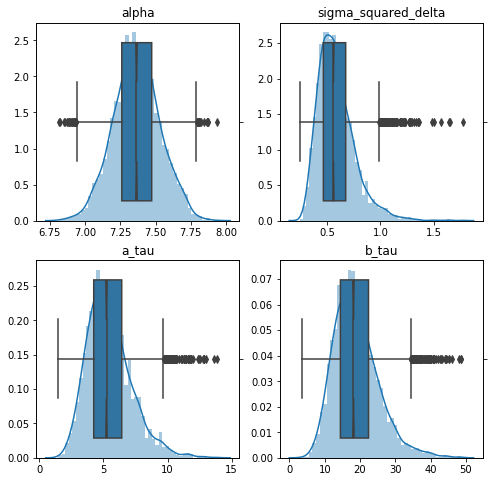

In [17]:
# graph all of the important distributions for time hyper-paramers
with time_model:
    imp_dists = ['alpha', 'sigma_squared_delta', 'a_tau', 'b_tau']
#     print(np.mean(trace[imp_dists[0]]))
    fig, axs = plt.subplots(2,2, figsize = (8,8))
    for i in range(len(imp_dists)):
        ax1 = axs[int(i/2)][i%2]
        ax2 = ax1.twinx()
        ax2.set(ylim=(-.25, .25))
        var = imp_dists[i]
        sns.distplot(trace[var], ax=ax1).set_title(var);
        sns.boxplot(trace[var], ax=ax2, notch=True)
        print(var + ": " + str(np.mean(trace[var])) + "(" + str(np.std(trace[var])) + ")")


In [ ]:
# graph all of the important distributions for graph hyper-paramers
with graph_model:
    imp_dists = ['sigma_squared_b', 'beta_0', 'beta_F', 'beta_d']
#    fig, axs = plt.subplots(2,2, figsize = (8,8))
    for i in range(len(imp_dists)):
#         ax1 = axs[int(i/2)][i%2]
#         ax2 = ax1.twinx()
#         ax2.set(ylim=(-.25, .25))
        var = imp_dists[i]
#         sns.distplot(trace[var], ax=ax1).set_title(var);
#         sns.boxplot(trace[var], ax=ax2, notch=True)
        print(var + ": " + str(np.mean(trace[var])) + "(" + str(np.std(trace[var])) + ")")


In [20]:
a_x_prediction = []
t_x_prediction = []
# Sample the a_x, t_x latent variables for the prediction tweets
with pm.Model() as time_prediction:
    i_prime = 0
    for i in range(num_root_tweets):
        if not partition_assignment[i]:
            t_x = pm.InverseGamma('tau_squared_{}'.format(i), alpha=hyperparams['a_tau'], beta=hyperparams['b_tau'])
            a_x = pm.Normal('alpha_{}'.format(i), mu=hyperparams['alpha'], tau=1/hyperparams['sigma_squared_delta'])        
            l_x = pm.Normal('log_{}'.format(i), mu=a_x, sd=t_x**0.5, observed=log_s_j_x[i_prime])
            i_prime += 1
        
# Run and fit our model
with time_prediction:
    trace = pm.sample(1000, tune=1000, cores=4)
    for i in range(num_root_tweets):
        if not partition_assignment[i]:
            a_x_prediction.append(np.mean(trace['alpha_{}'.format(i)]))
            t_x_prediction.append(np.mean(trace['tau_squared_{}'.format(i)]))
        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_51, tau_squared_51_log__, alpha_49, tau_squared_49_log__, alpha_47, tau_squared_47_log__, alpha_45, tau_squared_45_log__, alpha_43, tau_squared_43_log__, alpha_41, tau_squared_41_log__, alpha_39, tau_squared_39_log__, alpha_37, tau_squared_37_log__, alpha_35, tau_squared_35_log__, alpha_33, tau_squared_33_log__, alpha_31, tau_squared_31_log__, alpha_29, tau_squared_29_log__, alpha_27, tau_squared_27_log__, alpha_25, tau_squared_25_log__, alpha_23, tau_squared_23_log__, alpha_21, tau_squared_21_log__, alpha_20, tau_squared_20_log__, alpha_17, tau_squared_17_log__, alpha_15, tau_squared_15_log__, alpha_12, tau_squared_12_log__, alpha_11, tau_squared_11_log__, alpha_9, tau_squared_9_log__, alpha_7, tau_squared_7_log__, alpha_5, tau_squared_5_log__, alpha_3, tau_squared_3_log__, alpha_1, tau_squared_1_log__]
100%|██████████| 2000/2000 [01:14<00:00, 26.72it/s]


In [26]:
class Retweet(pm.Continuous):
    def __init__(self, alpha_x, t_x, S_x, m_t, t, T, *args, **kwargs):
        super(Retweet, self).__init__(*args, **kwargs)
        self.alpha_x = alpha_x
        self.t_x = t_x
        self.S_x = S_x
        self.m_t = m_t
        self.t = t
        self.T = T
    
    def logp(self, M):
        nCr = lambda x,y: math.factorial(x) / (math.factorial(y) * math.factorial(x - y))
        choose_func = theano.function([a,b], nCr(a,b))
        choose_term = tt.prod(choose_func(M, self.m_t))

        gauss = scipy.stats.norm(self.alpha_x, self.t_x)
        F = lambda x: gauss.cdf(x)
        f_func = theano.function([a,b], lambda x,y: (1 - F(x))**y)
        f_term = tt.prod(f_func(tt.log(self.t - self.T), M - self.m_t))


        rxn_term = tt.prod(gauss.pdf(self.S_x))

        return math.log(rxn_term * f_term * choose_term)

In [21]:
class Retweet(pm.Continuous):
    def __init__(self, alpha_x, t_x, S_x, m_t, t, T, d, f_x, i, global_params, *args, **kwargs):
        super(Retweet, self).__init__(*args, **kwargs)
        self.alpha_x = alpha_x
        self.t_x = t_x
        self.S_x = S_x
        self.m_t = m_t
        self.t = t
        self.T = T
        self.d = d
        self.f_x = f_x
        self.i = i
        self.beta_0 = global_params[0]
        self.beta_F = global_params[1]
        self.beta_d = global_params[2]
        self.sigma_squared_b = global_params[3]
    
    def logp(self, M):
        set_mu = self.beta_0 + self.beta_F * math.log(f_x + 1) + self.beta_d * math.log(d + 1)
        b = pm.Deterministic('b_{}'.format(i), pm.math.invlogit(pm.Normal('logit_b_{}'.format(i), mu=set_mu, tau=1/self.sigma_squared_b)))
        
        nCr = lambda x,y: math.factorial(x) / (math.factorial(y) * math.factorial(x - y))
        choose_func = theano.function([a,b], nCr(a,b))
        gauss = scipy.stats.norm(self.alpha_x, self.t_x)
        F = lambda x: gauss.cdf(x)
        f_func = theano.function([a,b], lambda x,y: (1 - F(x))**y)
        
        choose_term_1 = tt.prod(choose_func(M, self.m_t))        
        f_term = tt.prod(f_func(tt.log(self.t - self.S_x), M - self.m_t))
        choose_term_2 = tt.prod(choose_func(self.f_x, M))
        binomial_term = (b ** M) * (1 - b) ** (f_x - M)

        return math.log(choose_term_1 * f_term * choose_term_2 * binomial_term) if M >= m_t else -np.inf

In [20]:
beta_0 = None
beta_F = None
beta_d = None
sigma_squared_b = None

with graph_model:
    beta_0 = np.mean(trace['beta_0'])
    beta_F = np.mean(trace['beta_F'])
    beta_d = np.mean(trace['beta_d'])
    sigma_squared_b = np.mean(trace['sigma_squared_b'])

global_params = [beta_0, beta_F, beta_d, sigma_squared_b]

NameError: name 'graph_model' is not defined

In [27]:
with pm.Model() as graph_prediction:
    for i in range(len(T)):
        # TODO: Generate S_x, m_t, t for each prediction tweet
        likelihood = Retweet('likelihood_' + str(i), alpha_x = a_x_prediction[i], t_x = t_x_prediction[i], S_x = S_x[i], m_t = m_t[i], t = t[i], T = T[i], d= d[i], f_x = f_x[i], i, global_params)
        
with graph_prediction:
    trace = pm.sample(1000, tune=1000, cores=4)

NameError: name 'self' is not defined